# Pytorch Classification Neural Network

## Useful resources:

* [Introduction to PyTorch - YouTube Series](https://pytorch.org/tutorials/beginner/introyt.html)
 (Work through sections 1 to 6)
* Dataset we are working with: [Breast Cancer Wisconsin Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)
* [PyTorch NN Guide](https://coderzcolumn.com/tutorials/artificial-intelligence/guide-to-create-simple-neural-networks-using-pytorch)


In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

Load the Breast Cancer Wisconsin Dataset.

In [ ]:
from sklearn import datasets
X, y = datasets.load_breast_cancer(return_X_y = True)

Split the datset into a training set and a test set. And convert to PyTorch tensors using torch.tensor() method.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

X_train, X_test, Y_train, Y_test = torch.tensor(X_train, dtype=torch.float32),\
                                   torch.tensor(X_test, dtype=torch.float32),\
                                   torch.tensor(y_train, dtype=torch.float32),\
                                   torch.tensor(y_test, dtype=torch.float32)

Visualize the Training and Testing Data.

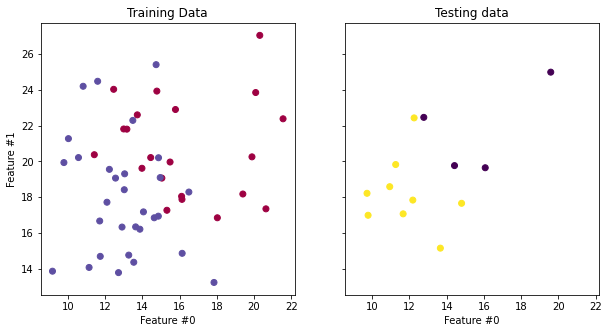

In [ ]:
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()

Normalize Data

In [ ]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean)/ std
X_test = (X_test - mean)/ std

Initialize Model Weights

In [ ]:
def InitializeWeights(layer_sizes, scale=0.1):
    weights = []
    for i, units in enumerate(layer_sizes):
        if i==0:
            w = torch.rand(units,features, dtype=torch.float32)
        else:
            w = torch.rand(units,layer_sizes[i-1], dtype=torch.float32)

        b = torch.rand(units, dtype=torch.float32)

        if scale: ## Scale weights
            w = w*scale
            b = b*scale

        w.requires_grad=True ## Set requires grad after weights are updated with scale
        b.requires_grad=True

        weights.append([w,b])

    return weights

Activation for Hidden Layers

In [ ]:
def Relu(tensor):
    return torch.maximum(tensor, torch.zeros_like(tensor)) # max(0,x)

Activation for Last Layer

In [ ]:
def Sigmoid(tensor):
    return 1 / (1 + torch.exp(-tensor))

In [ ]:
tensor = torch.tensor([1,2,3,4,5])

Sigmoid(tensor), torch.nn.Sigmoid()(tensor)

(tensor([0.7311, 0.8808, 0.9526, 0.9820, 0.9933]),
 tensor([0.7311, 0.8808, 0.9526, 0.9820, 0.9933]))

Single Layer of Neural Network

In [ ]:
def LinearLayer(weights, input_data, activation=lambda x: x):
    w, b = weights
    out = torch.matmul(input_data, w.T) + b ## Multiply input by weights and add bias to it.
    return activation(out) ## Apply activation at last

Single Forward Pass through Data to Make Predictions

In [ ]:
def ForwardPass(weights, input_data):
    layer_out = input_data

    for i in range(len(weights[:-1])):
        layer_out = LinearLayer(weights[i], layer_out, Relu) ## Hidden Layer

    preds = LinearLayer(weights[-1], layer_out, Sigmoid) ## Final Layer

    return torch.clamp(preds.squeeze(), 0.01, 0.99)

Define Loss Function

In [ ]:
def NegLogLoss(actual, preds):
    loss = - actual * torch.log(preds) - (1 - actual) * torch.log(1 - preds)
    return loss.mean()

In [ ]:
y1 = torch.tensor([1,1,0, 0,1])
y2 = torch.tensor([0.7,0.1,0.69, 0.1,0.23])

NegLogLoss(y1, y2)

tensor(1.0811)

In [ ]:
from sklearn.metrics import log_loss

log_loss(y1.detach().numpy(), y2.detach().numpy())

1.0810959234833717

Train Neural Network

In [ ]:
from torch import autograd

def TrainModel(X, Y, learning_rate, epochs):

    for i in range(1, epochs+1):
        preds = ForwardPass(weights, X) ## Make Predictions by forward pass through network

        loss = NegLogLoss(Y, preds) ## Calculate Loss

        loss.backward() ## Calculate Gradients

        with torch.no_grad():
            for j in range(len(weights)): ## Update Weights
                weights[j][0] -= learning_rate * weights[j][0].grad ## Update Weights
                weights[j][1] -= learning_rate * weights[j][1].grad ## Update Biases

                weights[j][0].grad = None
                weights[j][1].grad = None

        if i % 100 == 0: ## Print NegLogLoss every 100 epochs
            print("NegLogLoss : {:.2f}".format(loss))

In [ ]:
torch.manual_seed(42) ##For reproducibility.This will make sure that same random weights are initialized each time.

epochs = 2500
learning_rate = torch.tensor(1/1e2) # 0.01
layer_sizes = [5,10,15,1] ## Layer sizes including last layer

weights = InitializeWeights(layer_sizes) ## Initialize Weights

TrainModel(X_train, Y_train, learning_rate, epochs)

NegLogLoss : 0.69
NegLogLoss : 0.69
NegLogLoss : 0.68
NegLogLoss : 0.68
NegLogLoss : 0.67
NegLogLoss : 0.67
NegLogLoss : 0.65
NegLogLoss : 0.63
NegLogLoss : 0.56
NegLogLoss : 0.46
NegLogLoss : 0.38
NegLogLoss : 0.32
NegLogLoss : 0.28
NegLogLoss : 0.25
NegLogLoss : 0.23
NegLogLoss : 0.20
NegLogLoss : 0.19
NegLogLoss : 0.17
NegLogLoss : 0.16
NegLogLoss : 0.15
NegLogLoss : 0.14
NegLogLoss : 0.13
NegLogLoss : 0.12
NegLogLoss : 0.11
NegLogLoss : 0.11


Make Predictions

In [ ]:
train_preds = ForwardPass(weights, X_train)

train_preds = torch.as_tensor(train_preds > 0.5, dtype=torch.float32)

train_preds[:5], Y_train[:5]

(tensor([0., 0., 0., 1., 1.]), tensor([0., 0., 0., 1., 1.]))

In [ ]:
test_preds = ForwardPass(weights, X_test)

test_preds = torch.as_tensor(test_preds > 0.5, dtype=torch.float32)

test_preds[:5], Y_test[:5]

(tensor([0., 1., 1., 0., 1.]), tensor([0., 1., 1., 0., 1.]))

Evaluate Performance of Neural Network

In [ ]:
from sklearn.metrics import accuracy_score

print("Train Accuracy : {:.2f}".format(accuracy_score(Y_train, train_preds)))
print("Test  Accuracy : {:.2f}".format(accuracy_score(Y_test, test_preds)))

Train Accuracy : 0.98
Test  Accuracy : 0.85
